In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import curve_fit

#turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#load ihmp runtime dataframe
ihmp_runtime = pd.read_csv("../results/ihmp-runtime-all.csv")
ihmp_runtime.drop(columns=['factor'], inplace=True)
#load uc runtime dataframe
uc_runtime = pd.read_csv("../results/uc-runtime-all.csv")

#add log of n features
#ihmp_runtime['log time (s)'] = np.log(ihmp_runtime['time (s)'])
#uc_runtime['log time (s)'] = np.log(uc_runtime['time (s)'])
#remove index column
ihmp_runtime.drop(columns=['index'], inplace=True)
uc_runtime.drop(columns=['index'], inplace=True)

In [3]:
#fit linear curve to Joint-RPCA runtimes
def line_fit(x, a, b):
    return a*x + b

def line_fit_ihmp(x, a):
    return a*x + 1.224

def line_fit_uc(x, a, b):
    return a*x + 4.598

def exp_curve_joint(x, a, b, c):
    return a * np.exp(b * x/2000) + c

def exp_curve_joint_ihmp(x, a, b):
    return a * np.exp(b * x/2000) + np.log(1.224)

def exp_curve_joint_uc(x, a, b):
    return a * np.exp(b * x/2000) + np.log(4.598)

#fit exponential curve to MMvec runtimes
def exp_curve_fit(x, a, b, c):
    return a * np.exp(b * x/1000) + c

def exp_curve_fit_ihmp(x, a, b):
    return a * np.exp(b * x/1000) + np.log(1309.9)

def exp_curve_fit_uc(x, a, b):
    return a * np.exp(b * x/1000) + np.log(5496.0)

In [4]:
#get all unique % of features
p_features_all = uc_runtime['% features'].astype(float).unique()
p_features_all.sort()
p_features_all

array([  4.84,   5.79,   7.69,   8.65,   9.6 ,  10.46,  11.35,  13.14,
        14.94,  19.41,  23.89,  30.  ,  35.  ,  40.  , 100.  ])

In [5]:
popt_ihmp, _ = curve_fit(exp_curve_fit, ihmp_runtime['n features'][10:], 
                         ihmp_runtime['time (s)'][10:])

popt_uc, _ = curve_fit(exp_curve_fit, uc_runtime['n features'][10:], 
                       uc_runtime['time (s)'][10:], maxfev=2000)
#print estimated params
print("Estimated params for MMvec-iHMP:", popt_ihmp)
print("Estimated params for MMvec-UC:", popt_uc)

Estimated params for MMvec-iHMP: [ 1.26268544e+03  2.15452267e-01 -1.05007216e+04]
Estimated params for MMvec-UC: [3.18261536e-07 2.54783679e+00 6.09569237e+03]


In [6]:
#repeat for Joint-RPCA
joint_popt_ihmp, _ = curve_fit(exp_curve_joint, ihmp_runtime['n features'][0:10], 
                               ihmp_runtime['time (s)'][0:10], maxfev=2000)
#repeat for uc
joint_popt_uc, _ = curve_fit(exp_curve_joint, uc_runtime['n features'][0:10], 
                             uc_runtime['time (s)'][0:10], maxfev=2000)
#print estimated params
print("Estimated params for Joint-RPCA-iHMP:", joint_popt_ihmp)
print("Estimated params for Joint-RPCA-UC:", joint_popt_uc)

Estimated params for Joint-RPCA-iHMP: [ 4.82905572e+01  1.07459290e-02 -4.97785267e+01]
Estimated params for Joint-RPCA-UC: [ 2.73021670e+01  2.17970970e-02 -2.64933689e+01]


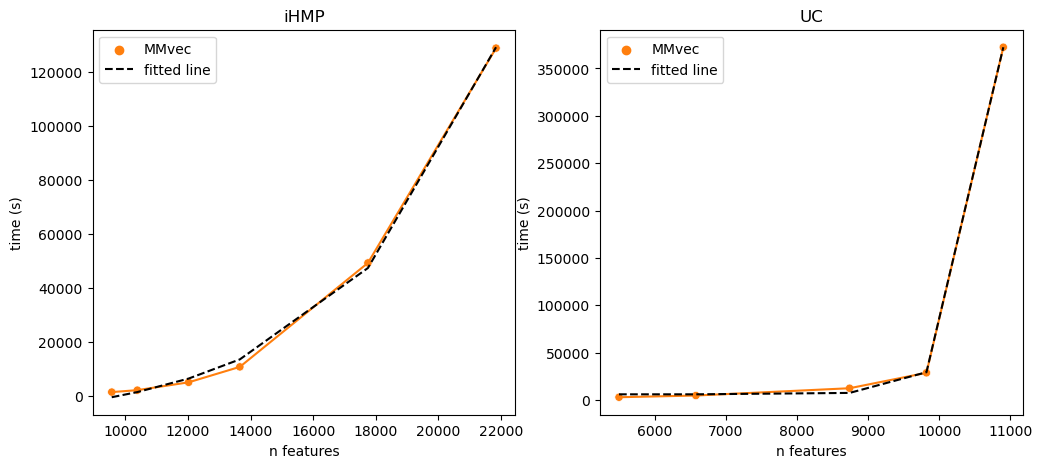

In [7]:
fig, axn = plt.subplots(1,2, figsize=(12,5))

ihmp_mmvec = ihmp_runtime[ihmp_runtime['method'] == 'MMvec']
uc_mmvec = uc_runtime[uc_runtime['method'] == 'MMvec']

xaxis = 'n features'

for ax_, df_, fit_, popt_, cohort_ in zip(axn.flatten(), 
                                          [ihmp_mmvec, uc_mmvec],
                                          [exp_curve_fit, exp_curve_fit],
                                          [popt_ihmp, popt_uc], ['iHMP', 'UC']):

    sns.scatterplot(ax=ax_, data=df_, x=xaxis, y='time (s)', 
                    hue='method', style='method', 
                    palette={'MMvec':'tab:orange'})
    ax_.plot(df_[xaxis], df_['time (s)'], 
            'tab:orange', label=None)
    ax_.plot(df_[xaxis], 
            fit_(df_[xaxis], *popt_), 'k--',
            label='fitted line')
    ax_.set_xlabel(xaxis)
    ax_.set_ylabel('time (s)')
    ax_.legend()
    ax_.set_title(cohort_)

plt.show()

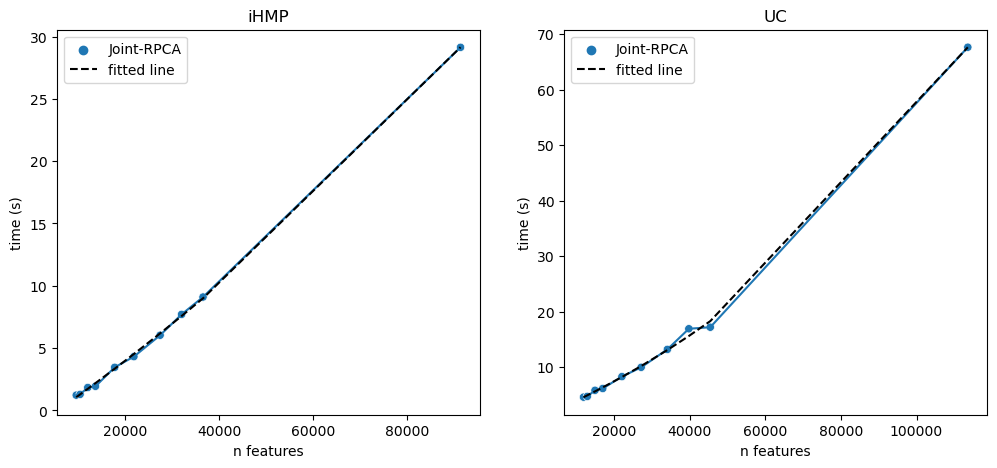

In [11]:
fig, axn = plt.subplots(1,2, figsize=(12,5))

ihmp_joint = ihmp_runtime[ihmp_runtime['method'] == 'Joint-RPCA']
uc_joint = uc_runtime[uc_runtime['method'] == 'Joint-RPCA']
xaxis = 'n features'

for ax_, df_, fit_, popt_, cohort_ in zip(axn.flatten(), 
                                         [ihmp_joint, uc_joint],
                                         [exp_curve_joint, exp_curve_joint],
                                         [joint_popt_ihmp, joint_popt_uc], 
                                         ['iHMP', 'UC']):

    sns.scatterplot(ax=ax_, data=df_, x=xaxis, y='time (s)', 
                    hue='method', style='method', 
                    palette={'Joint-RPCA':'tab:blue'})
    ax_.plot(df_[xaxis], df_['time (s)'], 
            'tab:blue', label=None)
    ax_.plot(df_[xaxis], 
            fit_(df_[xaxis], *popt_), 'k--',
            label='fitted line')
    ax_.set_xlabel(xaxis)
    ax_.set_ylabel('time (s)')
    ax_.legend()
    ax_.set_title(cohort_)

plt.show()

In [12]:
## estimate data points for MMvec-iHMP based on fitted curve
p_features = [4.84, 5.79, 7.69, 8.65, 9.6, 30.0, 35.0, 40.0]
n_features = [int(0.01 * p * 91429.00) for p in p_features]
est_time = exp_curve_fit(np.array(n_features), *popt_ihmp)

mmvec_extra_df = pd.DataFrame({'method':'MMvec', 'time (s)':est_time,
                               'n features':n_features, '% features':p_features})
mmvec_extra_df['time (hr)'] = mmvec_extra_df['time (s)'] / 3600
mmvec_extra_df

,method,time (s),n features,% features,time (hr)
0,MMvec,-7.224742e+03,4425,4.84,-2.006873
1,MMvec,-6.551061e+03,5293,5.79,-1.819739
2,MMvec,-4.758362e+03,7030,7.69,-1.321767
3,MMvec,-3.562557e+03,7908,8.65,-0.989599
4,MMvec,-2.133973e+03,8777,9.60,-0.592770
5,MMvec,4.547914e+05,27428,30.00,126.330957
6,MMvec,1.235524e+06,32000,35.00,343.201025
7,MMvec,3.325559e+06,36571,40.00,923.766330


In [38]:
# #repeat for Joint-RPCA (iHMP)
# p_features = [4.84, 5.79, 7.69, 8.65, 9.6]
# n_features = [int(0.01 * p * 91429.00) for p in p_features]
# est_time = exp_curve_joint_ihmp(np.array(n_features), *joint_popt_ihmp)

# joint_extra_df = pd.DataFrame({'method':'Joint-RPCA', 'time (s)':est_time,
#                                'n features':n_features, '% features':p_features})
# joint_extra_df['time (hr)'] = joint_extra_df['time (s)'] / 3600
# joint_extra_df

In [13]:
ihmp_runtime_all = ihmp_runtime.copy()
ihmp_runtime_all = pd.concat([ihmp_runtime_all, mmvec_extra_df], ignore_index=True)
ihmp_runtime_all['time (hr)'] = ihmp_runtime_all['time (s)'] / 3600
ihmp_runtime_all

,method,n features,time (s),% features,time (hr)
0,Joint-RPCA,9562,1.223706e+00,10.46,0.000340
1,Joint-RPCA,10380,1.283670e+00,11.35,0.000357
2,Joint-RPCA,12018,1.837933e+00,13.14,0.000511
3,Joint-RPCA,13655,1.932425e+00,14.94,0.000537
4,Joint-RPCA,17748,3.457007e+00,19.41,0.000960
5,Joint-RPCA,21842,4.316535e+00,23.89,0.001199
6,Joint-RPCA,27428,6.031864e+00,30.00,0.001676
7,Joint-RPCA,32000,7.704982e+00,35.00,0.002140
8,Joint-RPCA,36571,9.098438e+00,40.00,0.002527
9,Joint-RPCA,91429,2.913679e+01,100.00,0.008094


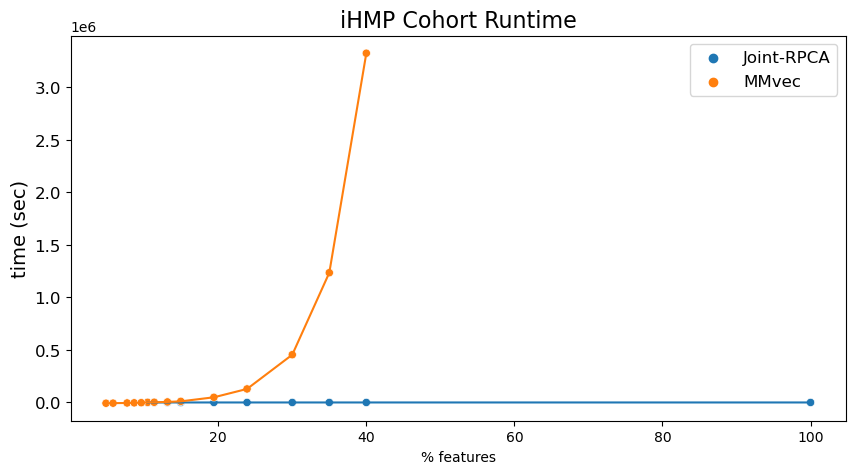

In [15]:
#estimate additional runtimes for MMvec using runtime
plt.figure(figsize=(10,5))
sns.scatterplot(data=ihmp_runtime_all, x='% features', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
sns.lineplot(data=ihmp_runtime_all, x='% features', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
#log y axis
#plt.yscale('log')
#increase font size
plt.ylabel('time (sec)', fontsize=14)
plt.yticks(fontsize=12)

#keep only half of the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], fontsize=12)

#get yticks
y_lim1 = plt.gca().get_ylim()
y_ticks = plt.gca().get_yticks()

#change xticks labels
#all_p_features = sorted(list(ihmp_runtime_all['% features'].unique()))
#all_n_features = sorted(list(ihmp_runtime_all['n features'].unique()))
#x_labels = ['{:,}\n({}%)'.format(round(n), p) for p, n in zip(all_p_features, 
#                                                              all_n_features)]
#plt.xticks(list(range(0,10)), x_labels, fontsize=10)
#plt.xlabel('number and % of features', fontsize=14)

#add second y axis with minutes instead of seconds
# plt.twinx()
# time_in_hr = [round(t / 3600, 1) for t in y_ticks]
# plt.yticks(y_ticks, labels=time_in_hr, fontsize=12)
# plt.ylabel('time (hr)', fontsize=14)
# plt.ylim(y_lim1)  # Match the y-axis limits

plt.title('iHMP Cohort Runtime', fontsize=16)
plt.show()

In [17]:
#repeat for uc
p_features_uc = [10, 15, 20]
n_features_uc = [int(0.01 * p * 113576.00) for p in p_features_uc]
est_time_uc = exponential_curve(np.array(n_features_uc), *popt_uc)

extra_df_uc = pd.DataFrame({'method':'MMvec', 'time (s)':est_time_uc,
                            'n features':n_features_uc, '% features':p_features_uc})
extra_df_uc['index'] = [5, 6, 7]

In [19]:
uc_runtime_all = uc_runtime.copy()
uc_runtime_all = pd.concat([uc_runtime_all, extra_df_uc], ignore_index=True)
uc_runtime_all

,index,time (s),method,n features,% features
0,0,4.598135e+00,Joint-RPCA,11880.0,10.46
1,1,4.730030e+00,Joint-RPCA,12890.0,11.35
2,2,5.828597e+00,Joint-RPCA,14923.0,13.14
3,3,6.154361e+00,Joint-RPCA,16968.0,14.94
4,4,8.300842e+00,Joint-RPCA,22045.0,19.41
5,5,9.971474e+00,Joint-RPCA,27133.0,23.89
6,6,1.320132e+01,Joint-RPCA,34072.0,30.00
7,7,1.692315e+01,Joint-RPCA,39751.0,35.00
8,8,1.719847e+01,Joint-RPCA,45430.0,40.00
9,9,6.766100e+01,Joint-RPCA,113576.0,100.00


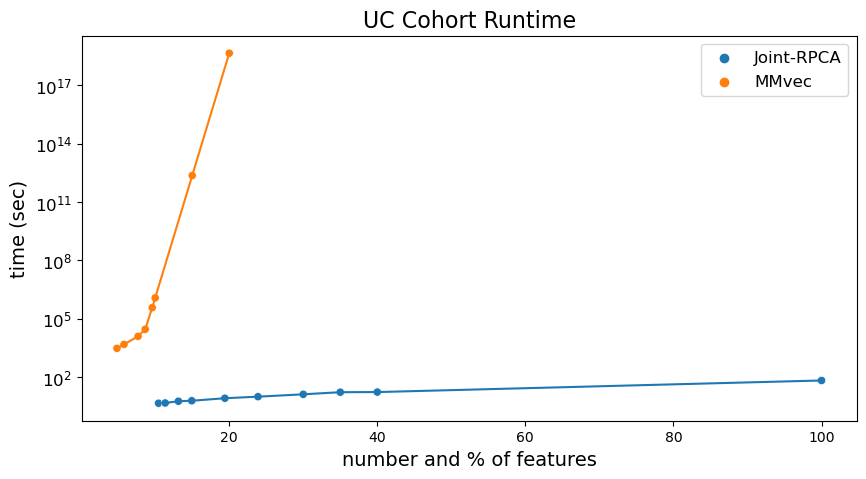

In [27]:
#estimate additional runtimes for MMvec using runtime
plt.figure(figsize=(10,5))
sns.scatterplot(data=uc_runtime_all, x='% features', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
sns.lineplot(data=uc_runtime_all, x='% features', y='time (s)', 
                hue='method', palette={'Joint-RPCA':'tab:blue',
                                       'MMvec':'tab:orange'})
#log y axis
plt.yscale('log')
#increase font size
plt.ylabel('time (sec)', fontsize=14)
plt.yticks(fontsize=12)

#keep only half of the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], fontsize=12)

#get yticks
y_lim1 = plt.gca().get_ylim()
y_ticks = plt.gca().get_yticks()

#change xticks labels
#all_p_features = sorted(list(uc_runtime_all['% features'][:10]))
#all_n_features = sorted(list(uc_runtime_all['n features'][:10]))
#x_labels = ['{:,}\n({}%)'.format(round(n), p) for p, n in zip(all_p_features, 
#                                                              all_n_features)]
#plt.xticks(list(range(0,10)), x_labels, fontsize=10)
plt.xlabel('number and % of features', fontsize=14)
plt.title('UC Cohort Runtime', fontsize=16)

plt.show()

## Compare runtimes

### Predict runtime for MMvec

In [22]:
ihmp_joint = ihmp_runtime_all[ihmp_runtime_all['method'] == 'Joint-RPCA']
uc_joint = uc_runtime_all[uc_runtime_all['method'] == 'Joint-RPCA']
ihmp_mmvec = ihmp_runtime_all[ihmp_runtime_all['method'] == 'MMvec']
uc_mmvec = uc_runtime_all[uc_runtime_all['method'] == 'MMvec']
ihmp_mmvec.reset_index(drop=True, inplace=True)
uc_mmvec.reset_index(drop=True, inplace=True)

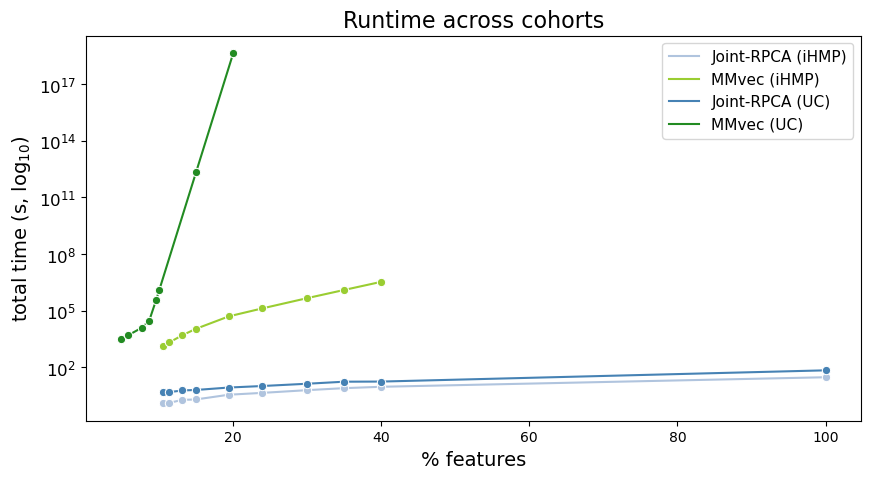

In [41]:
#estimate additional runtimes for MMvec using runtime
plt.figure(figsize=(10,5))

ihmp_palette = {'Joint-RPCA':'lightsteelblue', 'MMvec':'yellowgreen'}
uc_palette = {'Joint-RPCA':'steelblue', 'MMvec':'forestgreen'}

sns.lineplot(data=ihmp_runtime_all, x='% features', y='time (s)', 
             hue='method', palette=ihmp_palette, marker="o")

sns.lineplot(data=uc_runtime_all, x='% features', y='time (s)', 
             hue='method', palette=uc_palette, marker="o")
#log y axis
plt.yscale('log')
#increase font size
plt.ylabel('total time (s, log$_{10}$)', fontsize=14)
plt.yticks(fontsize=12)

#keep only half of the legend
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Joint-RPCA (iHMP)', 'MMvec (iHMP)', 
          'Joint-RPCA (UC)', 'MMvec (UC)']
plt.legend(handles[:4], labels, fontsize=11)

#get yticks
y_lim1 = plt.gca().get_ylim()
y_ticks = plt.gca().get_yticks()

#change xticks labels
all_p_features = sorted(list(ihmp_runtime_all['% features'].unique()))
#plt.xticks(list(range(0,10)), all_p_features, fontsize=12)
plt.xlabel('% features', fontsize=14)

#add text to every other point to show the time in seconds
# plt.text(-0.2, 45000, "Time (hr):", ha='left', fontsize=11)
# for i, p in enumerate(all_p_features):
#     if i % 3 == 0:
#         #joint-rpca
#         txt_ihmp_joint = ihmp_joint.loc[i, 'time (s)']
#         plt.text(i, txt_ihmp_joint, round(txt_ihmp_joint, 1), 
#                  fontsize=10, ha='center', va='top')
        
#         txt_uc_joint = uc_joint.loc[i, 'time (s)']
#         plt.text(i, txt_uc_joint, round(txt_uc_joint, 1), 
#                  fontsize=10, ha='center', va='bottom')

# plt.text(-0.2, 35, "Time (s):", ha='left', fontsize=11)   
# for i, p in enumerate(ihmp_mmvec['% features'].unique()):
#     if i % 2 == 0:
#         #MMvec text
#         txt_ihmp_mmvec = ihmp_mmvec.loc[i, 'time (s)']
#         plt.text(i, txt_ihmp_mmvec, round(txt_ihmp_mmvec/3600, 1), 
#                  fontsize=10, ha='center', va='top')
        
#         if i < 3:
#             txt_uc_mmvec = uc_mmvec.loc[i, 'time (s)']
#             plt.text(i, txt_uc_mmvec, round(txt_uc_mmvec/3600, 1), 
#                     fontsize=10, ha='center', va='bottom')
        
#         if i > 3 and i < 6:
#             txt_uc_mmvec = uc_mmvec.loc[i, 'time (s)']
#             plt.text(i, txt_uc_mmvec, round(txt_uc_mmvec/86400, 1), 
#                     fontsize=10, ha='center', va='bottom')

plt.title('Runtime across cohorts', fontsize=16)
plt.show()